## Description

This jupyter notebook aims to reproduce figures 3 and 4 from the manuscript and the respective figures in the supplementary material.

In this study we apply the PCMCI+ causal discovery algorithm to obtain causal networks connecting coupled and atmospheric modes of climate variability over
the Atlantic and Pacific for different periods.

We use the following indices from observational and reanalyses datasets:


| **Index**         | **Definition**             | **Region**                                      | **Dataset**                                      |
|---------------|-------------------------------------------------------|---------------------------------------------|------------------------------|
| **TNA**           | Area-weighted monthly SSTAs over the North Tropical Atlantic region              | 5.5–23.5°N, 58°–15°W                       | HadISST         |
| **Niño3.4**      | Area-weighted monthly SSTAs over the equatorial Pacific region                       | 5°N–5°S, 170°–120°W                         | HadISST         |
| **PNA**           | Leading EOF of (3-monthly averaged and area-weighted) SLP anomalies over the Pacific North America region | 20–85°N, 120°E–120°W     | NCEP-NCAR-R1  |
| **NAO**           | Leading EOF of (3-monthly averaged and area-weighted) SLP anomalies over the North Atlantic region | 20–80°N, 90°W-40°E         | NCEP-NCAR-R1  |
| **PWCu**     | Monthly zonal wind anomaly at 925 hPa over the equatorial Pacific region             | 6°N–6°S, 180°-150°E  |  NCEP-NCAR-R1  |
| **ATL3**          | Area-weighted monthly SSTAs over the equatorial Atlantic region                   | 3°N–3°S, 20°W–0°                            | HadISST         |
| AMV           | Monthly SSTAs averaged over the North Atlantic region                                 | 0–60°N, 80–0°W                             | HadISST         |
| PDV           | PC associated with 1st EOF of area-weighted monthly SSTAs over the North Pacific region| 20–70°N, 110°E–100°W                      | HadISST         |

## I.   Imports

In [2]:
import warnings
warnings.filterwarnings("ignore")  # Ignore warnings while loading
import numpy as np
from utils import Utils as utils
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.pcmci import PCMCI
from tigramite import data_processing as pp
from run_causal_analysis import run_obs_analysis as robs
from run_causal_analysis import run_sliding_window as rsw
from data_visualization import DataVisualization as viz
import xarray as xr
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.crs as ccrs
import pickle


## II. Settings and Parameters

In [3]:
"""
General settings the analysis and plotting the PCMCI+ results
"""
pc_alpha = 0.2  # Transparency value for plotting
detrend = False  # Flag indicating whether to detrend the data
smooth = False  # Flag indicating whether to apply smoothing to the data
stddz = False  # Flag indicating whether to standardize the data
seasonal = True  # Flag indicating whether to consider seasonal data
min_tau, max_tau = 0, 4  # Minimum and maximum values for tau
var_names = ["$TNA$", "$PNA$", "$Nino34$", "$PWC_{u}$", "$NAO$", "$ATL3$"]  # Names of variables
x = np.array([110, 10, 5, 18, 117, 130])  # Array of x-coordinates
y = np.array([13.5, 52, 0, 14, 52, 0])  # Array of y-coordinates
node_pos = {
    "x": x,
    "y": y,
    "transform": ccrs.PlateCarree(central_longitude=210),
}  # Dictionary containing node positions and coordinate reference system
list_titleperiods = [
    "1950-1983",
    "1950-1983 minus MEM",
    "1983-2014",
    "1983-2014 minus MEM",
]  # List of title periods
subtitles = ["1950-1970", "1960-1980", "1970-1990", "1980-2000", "1990-2010"]  # List of subtitles
case_str = ["raw", "iso"]  # List of case strings
node_posld = {
    "x": np.array([10, 4, 2.5, 4, 10, 8]),
    "y": np.array([1.3, 8, 1.3, 3.8, 8, 0.2]),
}  # Dictionary containing node positions for sliding window plotting

""" Create directories for saving figures and dataframes """
FIGS_DIR = "FIGS/OBS/"  # Directory for saving figures
DF_DIR = "DATA/OBS/"  # Directory for saving dataframes

viz.create_directories(FIGS_DIR, DF_DIR)  # Create directories for figures and dataframes


Directory 'FIGS/OBS/' already exists!
Directory 'DATA/OBS/' already exists!


## III. Load datasets, calculate indices and prepare dataframes

#### **! Adjust path to data and file names accordingly !**

In [6]:
# Paths to the observational and ensemble mean data
path_to_psl_em = "/work/bd1083/b380749/esmval/recipe_EM_psl_20230323_234348/preproc/dummy_diagnostic_1/psl/"
path_to_ua_em = "/work/bd1083/b380749/esmval/recipe_EM_20230323_233618/preproc/dummy_diagnostic_1/ua/"
path_to_ts_em = "/work/bd1083/b380749/esmval/recipe_EM_ts_20230323_234348/preproc/dummy_diagnostic_1/ts_landmask/"
path_to_psl_obs = "/work/bd0854/DATA/ESMValTool2/OBS/Tier2/NCEP-NCAR-R1/"
path_to_ua_obs = "/work/bd0854/DATA/ESMValTool2/OBS/Tier2/NCEP-NCAR-R1/"
path_to_ts_obs = "/work/bd1083/b380749/b380749/NetCDF/raw_netcdf_cmip6/obs/"

# Load the datasets
ds_psl_em = xr.open_dataset(
    path_to_psl_em
    + "CMIP6_MultiModelMean_historical_EnsembleMean_Amon_psl_1900-2014.nc"
)
ds_ua_em = xr.open_dataset(
    path_to_ua_em + "CMIP6_MultiModelMean_historical_EnsembleMean_Amon_ua_1900-2014.nc"
).sel(plev=92500)

ds_ts_em = xr.open_dataset(
    path_to_ts_em + "CMIP6_MultiModelMean_historical_EnsembleMean_Amon_ts_1900-2014.nc"
)

ds_ua_obs = (
    xr.open_dataset(
        path_to_ua_obs + "OBS6_NCEP-NCAR-R1_reanaly_1_Amon_ua_194801-202210.nc"
    )
    .sel(time=slice("1950-01-01", "2014-12-01"))
    .sel(plev=92500)
)
ds_psl_obs = xr.open_dataset(
    path_to_psl_obs + "OBS6_NCEP-NCAR-R1_reanaly_1_Amon_psl_194801-202210.nc"
).sel(time=slice("1950-01-01", "2014-12-01"))
ds_ts_obs = xr.open_dataset(
    path_to_ts_obs + "OBS_HadISST_reanaly_1_Amon_ts_187001-201712.nc"
).sel(time=slice("1950-01-16", "2014-12-16"))

# Interpolate datasets
ds_ts_obs = utils.interpolate_dataset(ds_ts_obs, ds_ts_em)
ds_psl_obs = utils.interpolate_dataset(ds_psl_obs, ds_psl_em)
ds_ua_obs = utils.interpolate_dataset(ds_ua_obs, ds_ua_em)

# Calculate indices and patterns and prepare the dataframes
(
    tig_data,
    tig_data_iso,
    amv_obs_dict,
    amv_obs_dict_iso,
    amv_obs_dict_veryraw,
    pdv_obs_dict,
    pdv_obs_dict_iso,
    pdv_obs_dict_veryraw,
    yearsarrobs,
    lenP1,
    lenP2,
) = robs.calculate_obs_indices(
    ds_ts_em=ds_ts_em,
    ds_psl_em=ds_psl_em,
    ds_ua_em=ds_ua_em,
    ds_ts_obs=ds_ts_obs,
    ds_psl_obs=ds_psl_obs,
    ds_ua_obs=ds_ua_obs,
    utils=utils,
)

### Plot AMV and PDV

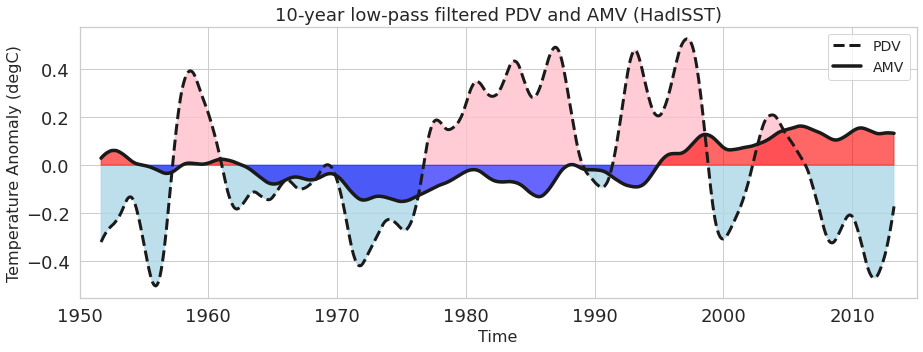

In [7]:
# Calculate low-pass filtered AMV and PDV
window = 41
amv_lp_short = utils.calculate_low_pass(amv_obs_dict_veryraw["amv_timeseries"], window)
pdv_lp_short = utils.calculate_low_pass(pdv_obs_dict_veryraw["pdv_timeseries"], window)

# Plot the AMV and PDV
yearsarrobs_mon = amv_obs_dict["amv_timeseries_lp"]["time.year"].values # Years for the monthly AMV and PDV (used for plotting)
viz.plot_obs_amv_pdv(amv_lp_short=amv_lp_short, pdv_lp_short=pdv_lp_short, yearsarrobs=yearsarrobs_mon ,FIGS_DIR=FIGS_DIR)

Save AMV and PDV data

In [8]:
# Save the dataframes
data_amv_pdv_obs_dict = {
    'amv_obs_dict.pickle': amv_obs_dict,
    'amv_obs_dict_veryraw.pickle': amv_obs_dict_veryraw,
    'amv_obs_dict_iso.pickle': amv_obs_dict_iso,
    'pdv_obs_dict.pickle': pdv_obs_dict,
    'pdv_obs_dict_veryraw.pickle': pdv_obs_dict_veryraw,
    'pdv_obs_dict_iso.pickle': pdv_obs_dict_iso
}

for filename, data in data_amv_pdv_obs_dict.items():
    with open(DF_DIR + filename, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

## IV. Plot time series (1950-2014)

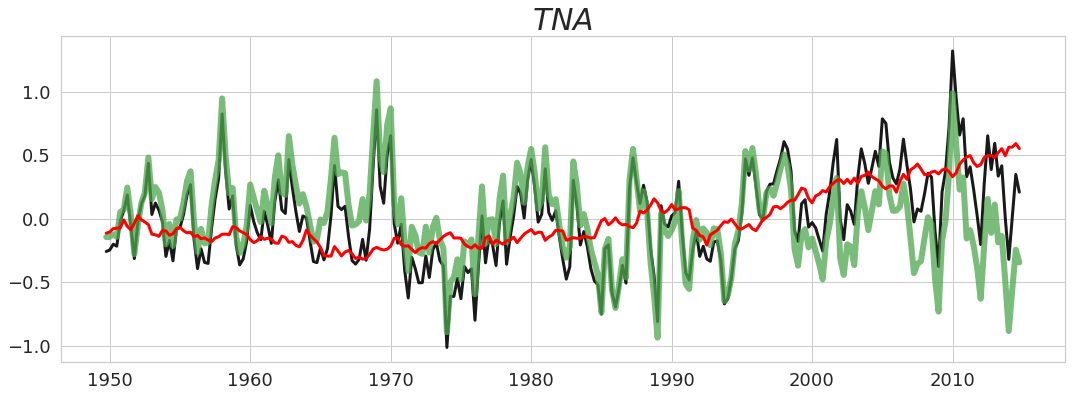

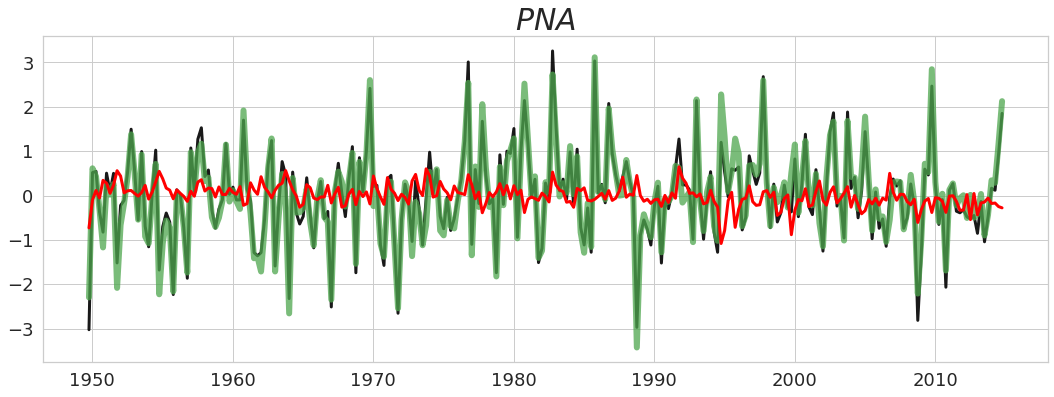

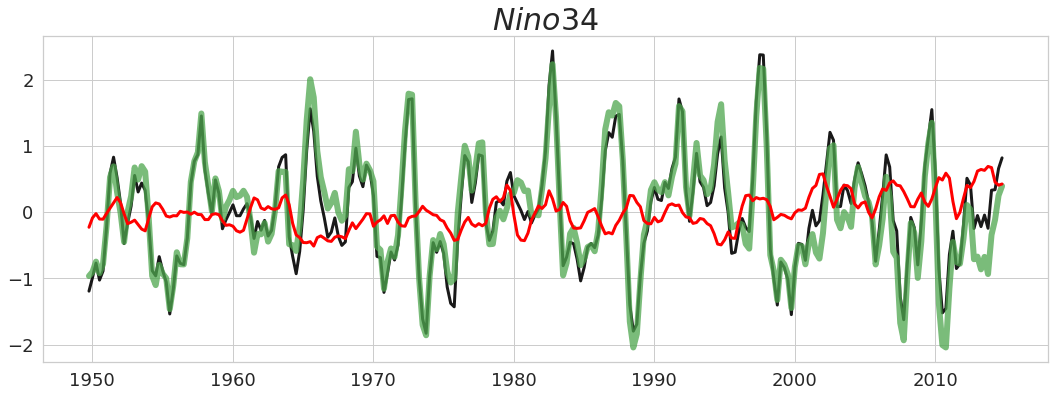

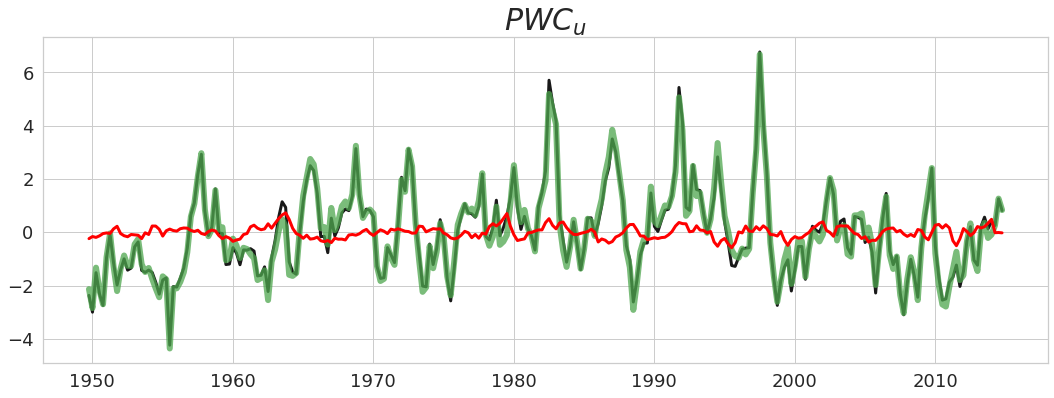

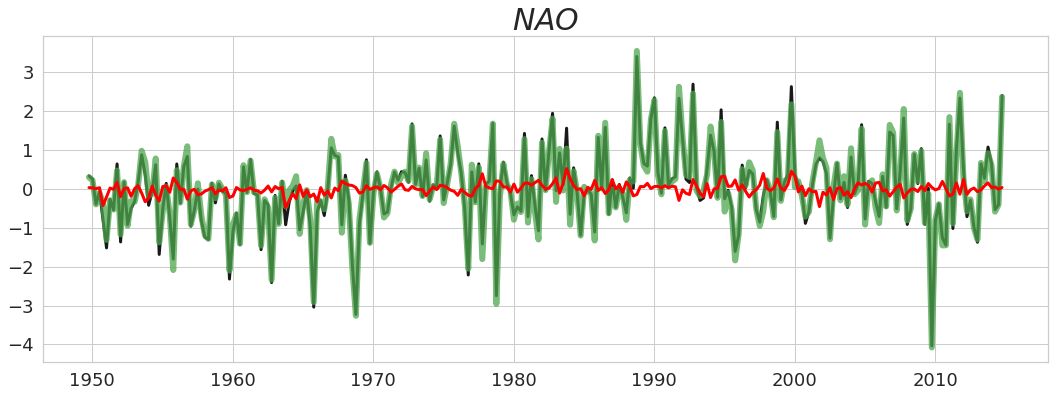

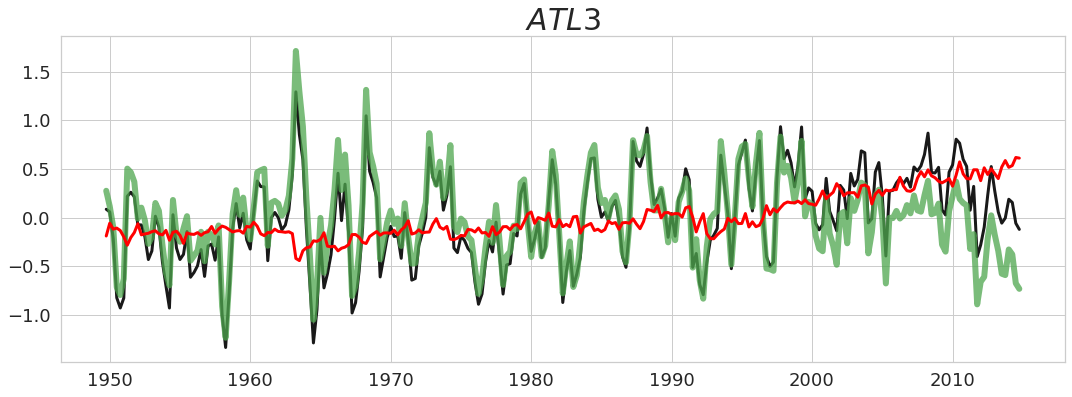

In [6]:
# Plot and save the dataframes
T, N = tig_data.shape
viz.plot_and_save_obs_dataframes(tig_data, tig_data_iso, N, var_names, yearsarrobs, FIGS_DIR, DF_DIR)

Load PCMCI dataframe (if needed)

In [3]:
# Load the dataframes
#tig_data=np.load('DATA/obs_tig_data.npy')
#tig_data_iso=np.load('DATA/obs_tig_data_iso.npy')
###################################

## V. Run causal analysis using PCMCI+ 



### 1. Two periods
This is first done for the different periods and scenarios: 
- 1950-1983
- 1950-1983 minus MEM
- 1983-2014
- 1983-2014 minus MEM


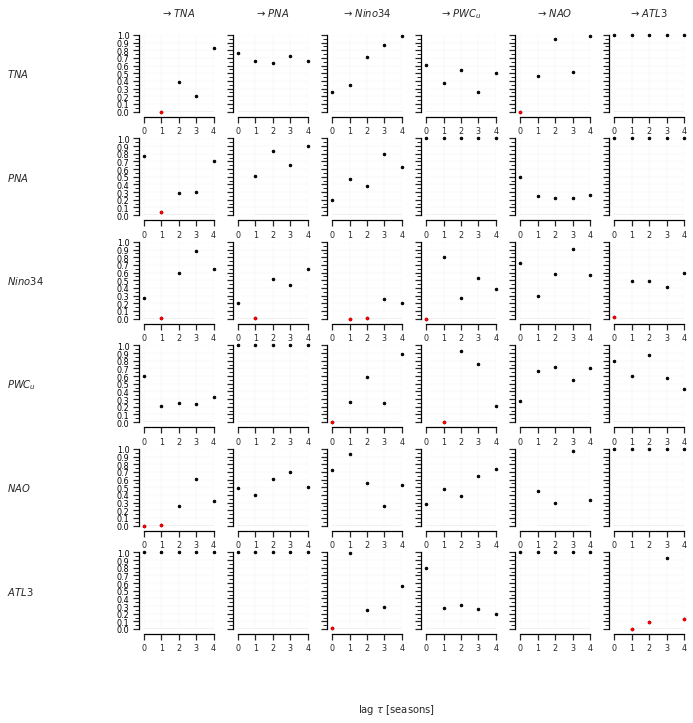

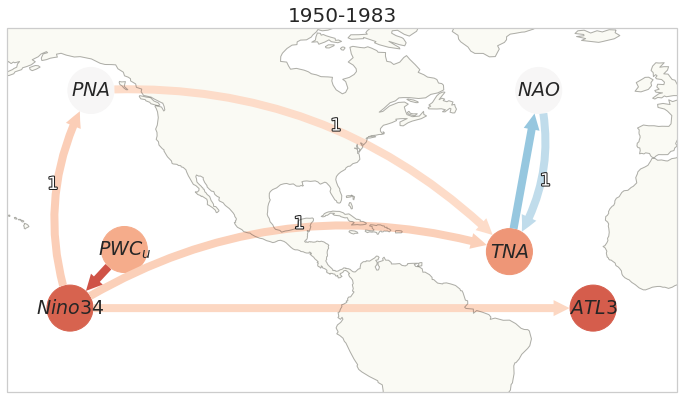

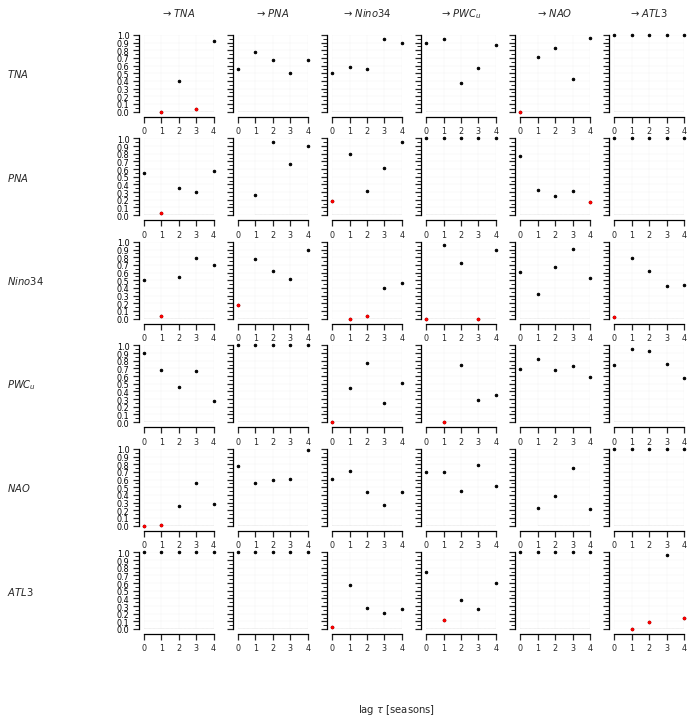

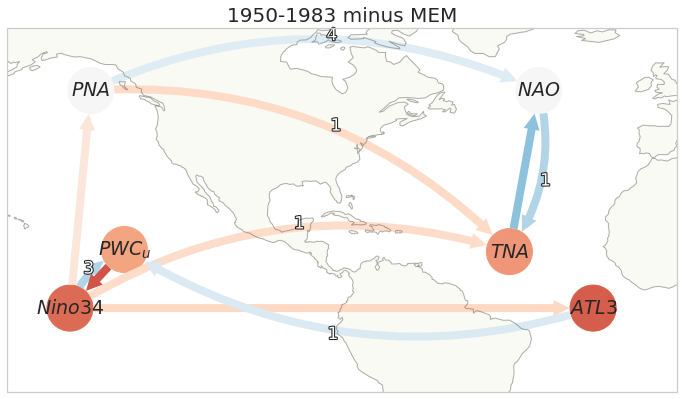

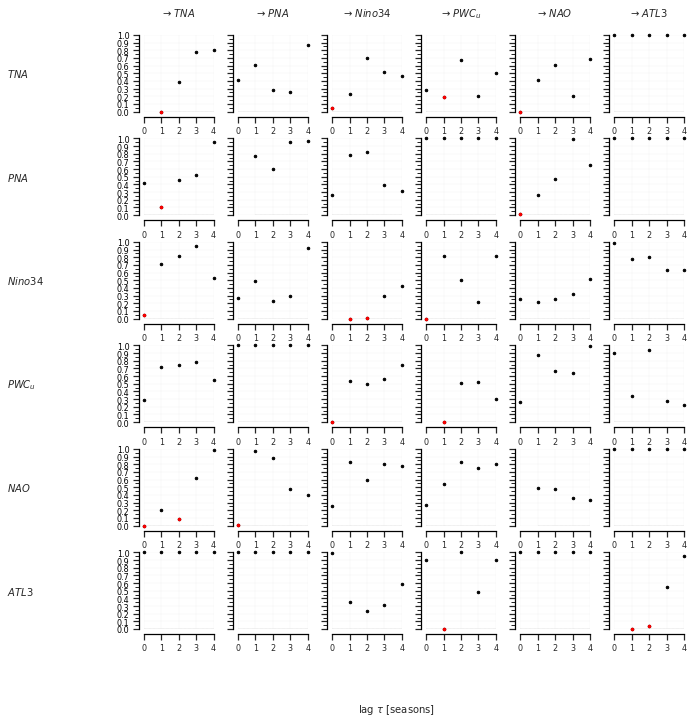

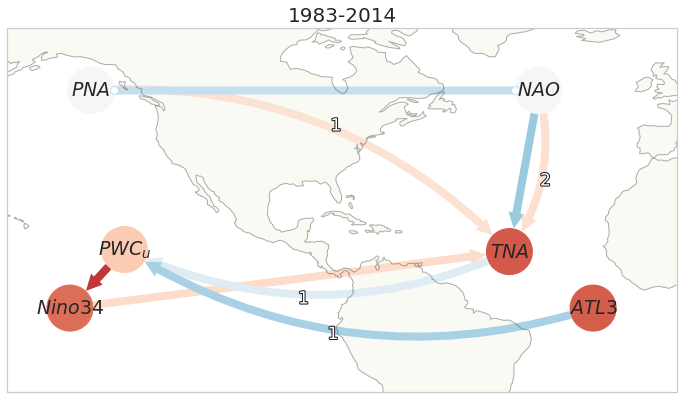

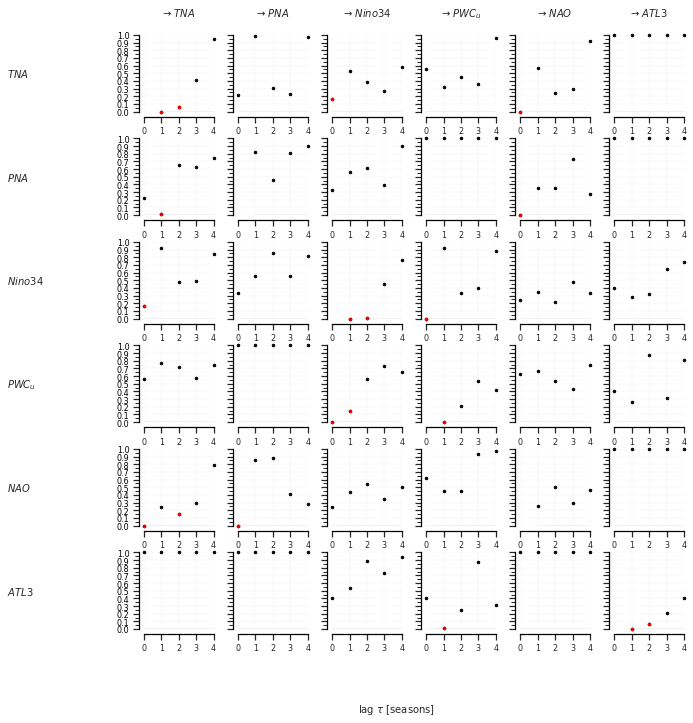

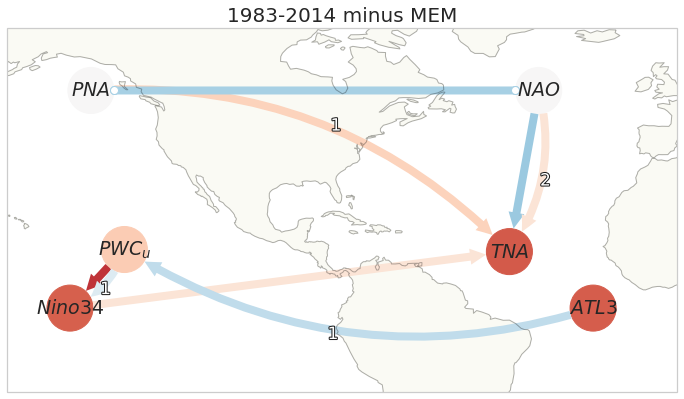

In [9]:
## Run the observational analysis for the raw and isolated indices (before and after subtracting MEM)

use_link_assumption = True # Flag indicating whether to use the link assumption

exp = 0
for exp_data in [
    tig_data[:lenP1],
    tig_data_iso[:lenP1],
    tig_data[-lenP2:],
    tig_data_iso[-lenP2:],
]:
    if stddz == True: # Standardize the data
        for var in range(N):
            exp_data[:, var] = exp_data[:, var] / np.std(exp_data[:, var])
    if detrend == True:
        for i in range(N): # Detrend the data
            exp_data[:, i] = utils.detrend_kw(exp_data[:, i])
    exp += 1 
    # Then we initialise the PCMCI dataframe
    dataframe = pp.DataFrame(exp_data, var_names=var_names, mask=None) 
    parcorr = ParCorr(significance="analytic") # We use the ParCorr test for independence
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr, verbosity=0)
    # correlations = pcmci.run_bivci(tau_min=min_tau,tau_max=max_tau, val_only=True)['val_matrix']
    if use_link_assumption: # if we use the link assumption, we build the test assumption
        test_assumption = robs.build_obs_assumption(max_tau=max_tau, pcmci=pcmci)
    else:
        test_assumption = None    
    # We then run the PCMCI+ analysis, plot and save the results
    robs.run_analysis_obs(pcmci, exp, list_titleperiods, FIGS_DIR,
                      var_names=var_names, 
                      min_tau=min_tau, max_tau=max_tau, pc_alpha=pc_alpha,
                     node_pos=node_pos,test_assumption=test_assumption)


### 2. Sliding window

Finally, we run the sliding window analysis with a window step of 10 years and length of 20 years starting from 1950:
- 1950-1970
- 1960-1980
- 1970-1990
- 1980-2000
- 1990-2010 

Set ```use_link_assumption = False``` to get results where no background knowledge is introduced


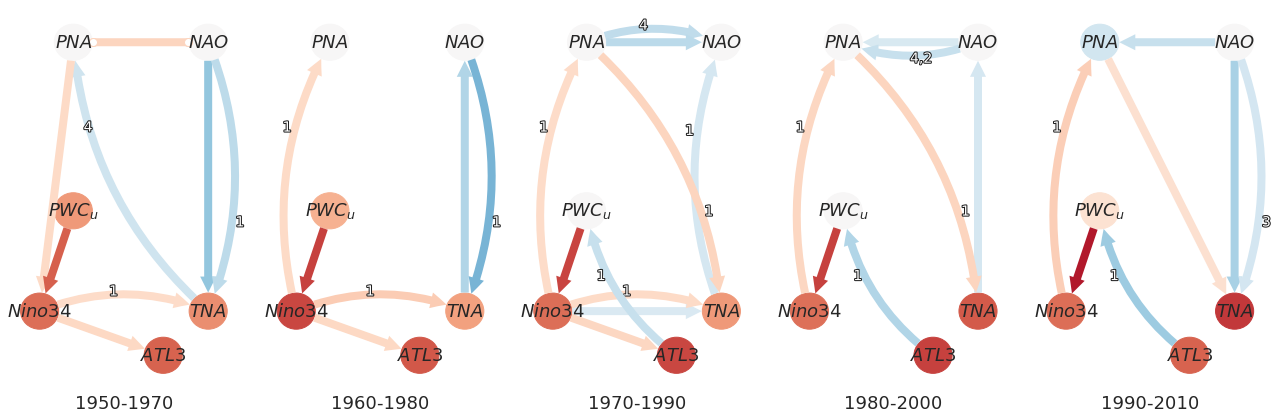

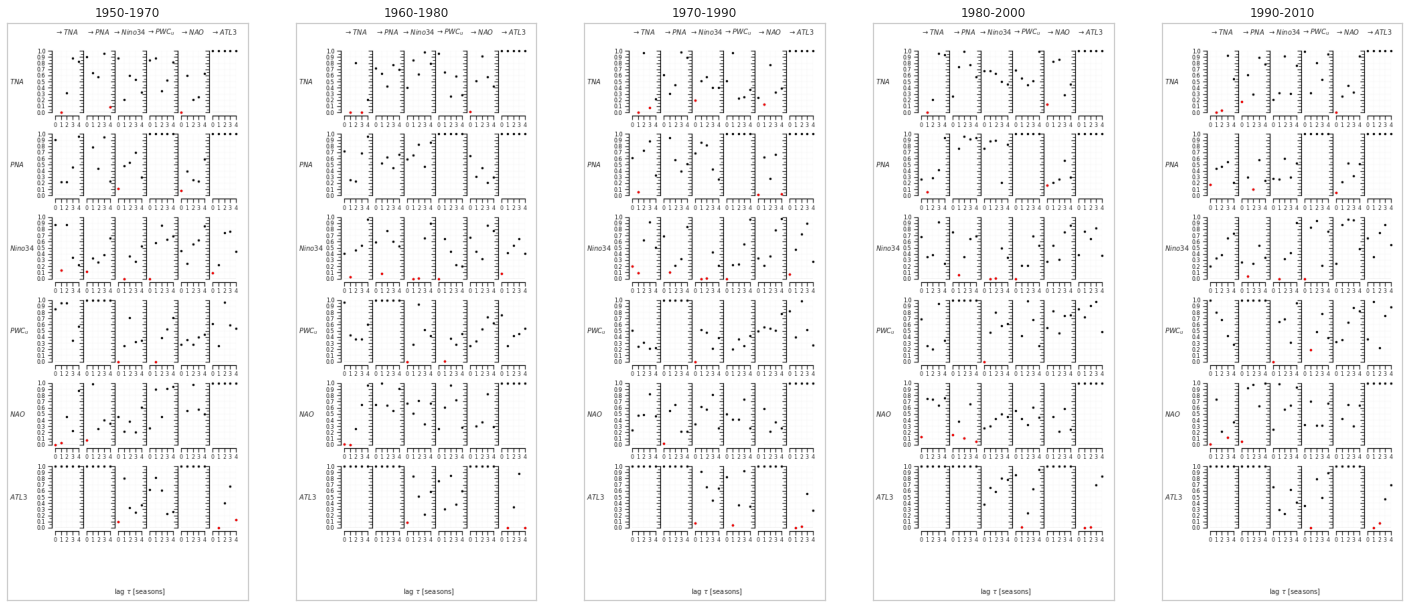

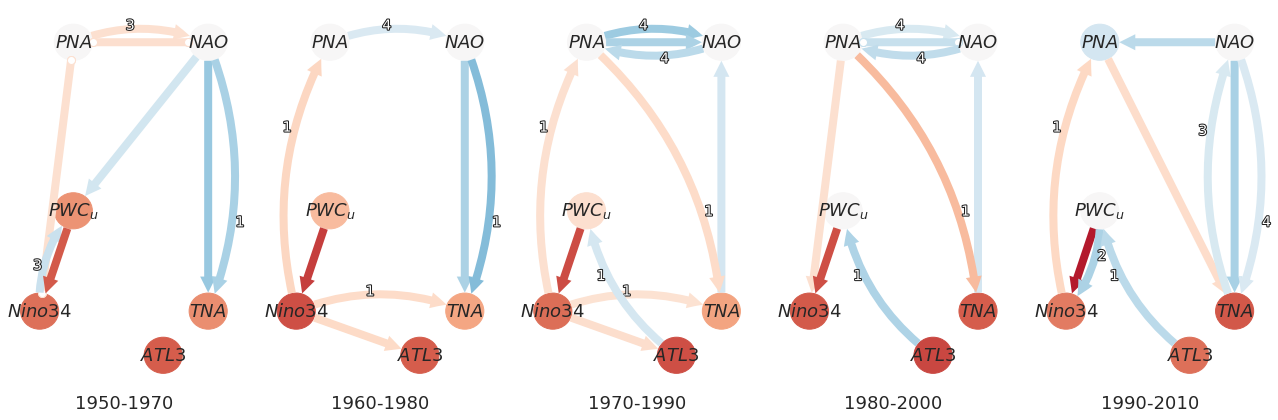

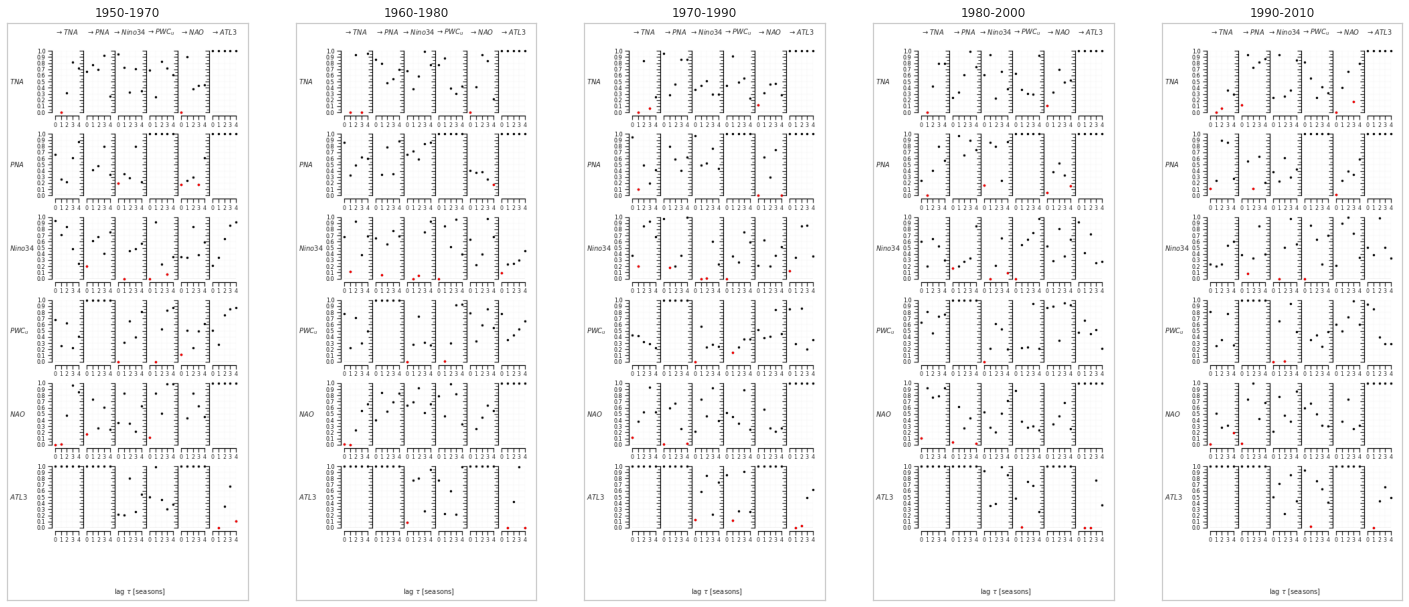

In [10]:
# Now, we will apply the PCMCI+ algorithm to the OBS datasets to obtain the causal networks for the sliding windows
# We apply the same settings to the raw and isolated indices  

use_link_assumption = True # Flag indicating whether to use the link assumption
sns.set(style="whitegrid")

for case, exp_data in enumerate([tig_data[:], tig_data_iso[:]]):
    if stddz == True:
        for var in range(N):
            exp_data[:, var] = exp_data[:, var] / np.std(exp_data[:, var])
    if detrend == True:
        for i in range(N):
            exp_data[:, i] = utils.detrend_kw(exp_data[:, i])
    # Initialise the PCMCI dataframe
    dataframe = pp.DataFrame(exp_data, var_names=var_names, mask=None) 
    cond_ind_test = ParCorr(significance="analytic") # We use the ParCorr test for independence
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test, verbosity=0) # We initialise the PCMCI object
    datatime = np.arange(len(exp_data))
    window_step = 40
    window_length = 80
    if use_link_assumption: # if we use the link assumption, we build the test assumption
        test_assumption = robs.build_obs_assumption(max_tau=max_tau, pcmci=pcmci)
    else:
        test_assumption = None 
    rsw.run_analysis_sliding(pcmci,
                      var_names=var_names, 
                      min_tau=min_tau, max_tau=max_tau, pc_alpha=pc_alpha,
                       window_step=window_step, window_length=window_length, 
                       subtitles=subtitles, node_posld=node_posld,test_assumption=test_assumption,
                       FIGS_DIR=FIGS_DIR)
